In [323]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
import optax
import jax
import jax.numpy as jnp

import fncs as fn

In [324]:
importlib.reload(fn)

<module 'fncs' from '/Users/lucaraffo/Desktop/codes/fncs.py'>

In [325]:
# synthetic data
rng = np.random.default_rng(123)
d = 8
A = rng.normal(size=(d, d))
Sigma_true = A @ A.T + 0.3 * np.eye(d)
n = 3000
X_np = rng.multivariate_normal(mean=np.zeros(d), cov=Sigma_true, size=n)

In [326]:
# score matching baseline
Sigma_sm = np.array(fn.score_matching_cov_zero_mean(jnp.asarray(X_np), ridge=1e-8))

In [327]:
print("||Sigma_sm - Sigma_true||_F/||Sigma_true||_F:", np.linalg.norm(Sigma_sm   - Sigma_true, 'fro')/np.linalg.norm(Sigma_true, 'fro'))

||Sigma_sm - Sigma_true||_F/||Sigma_true||_F: 0.05692179386096178


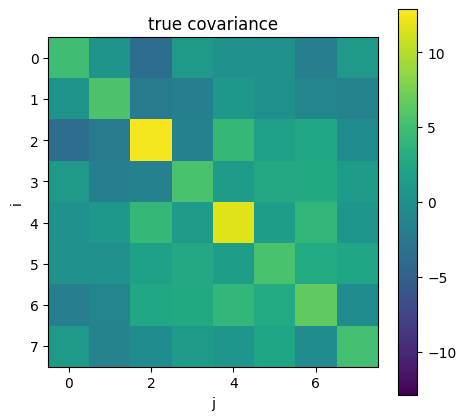

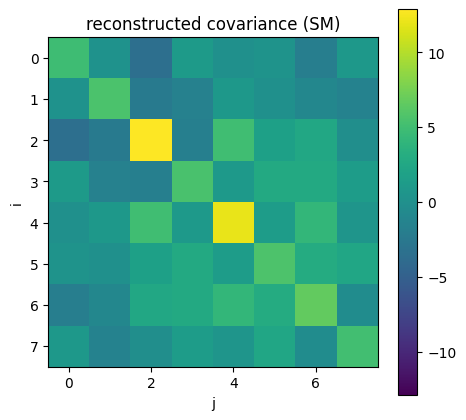

In [328]:
fn.plot_cov_heatmaps(Sigma_true, Sigma_sm,
                  title_true="true covariance",
                  title_rec ="reconstructed covariance (SM)")

In [ ]:
# w-grad MMD (RBF)
Sigma_rbf, theta_rbf, hist_rbf, Sigma_noise_rbf = fn.fit_cov_by_wgrad_mmd_jax(
    X_np, kernel="rbf", sigma_rbf=0.1,
    n_model=3000, seed_samples=7,
    iters=250, lr=5e-2, init_from_noisy_inverse=True
)

TypeError: sigma_from_theta() missing 1 required positional argument: 'd'

In [ ]:
print("||Sigma_rbf - Sigma_true||_F/||Sigma_true||_F:", np.linalg.norm(Sigma_rbf - Sigma_true, 'fro')/np.linalg.norm(Sigma_true, 'fro'))

||Sigma_rbf - Sigma_true||_F/||Sigma_true||_F: 0.05151375575230471


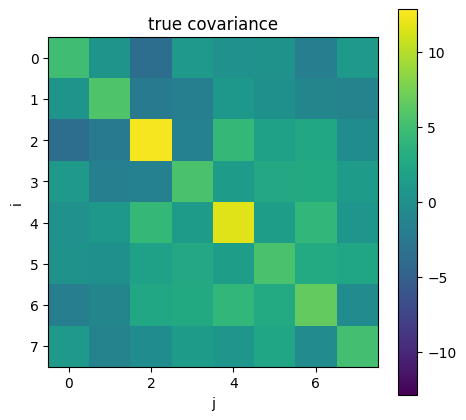

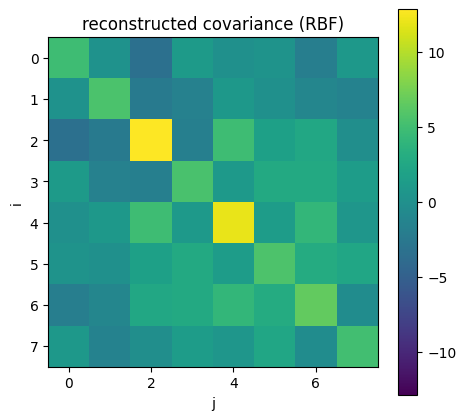

In [ ]:
fn.plot_cov_heatmaps(Sigma_true, Sigma_rbf,
                  title_true="true covariance",
                  title_rec ="reconstructed covariance (RBF)")

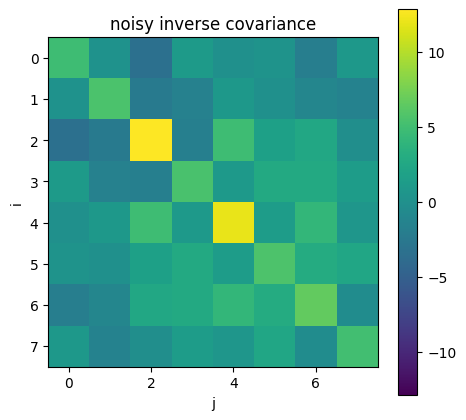

TypeError: Invalid shape (36,) for image data

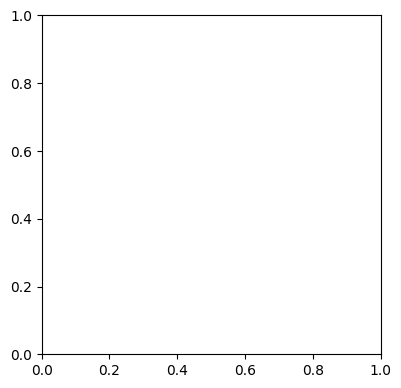

In [ ]:
fn.plot_cov_heatmaps(Sigma_noise_rbf, Sigma_rbf,
                  title_true="noisy inverse covariance",
                  title_rec ="reconstructed covariance (RBF)")

In [ ]:
# w-grad MMD (Polynomial, degree=5)
Sigma_poly, theta_poly, hist_poly, Sigma_noise_poly = fn.fit_cov_by_wgrad_mmd_jax(
    X_np, kernel="poly", degree=5, c=1.0,
    n_model=3000, seed_samples=11,
    iters=250, lr=5e-2, init_from_noisy_inverse=True
)

In [ ]:
print("||Sigma_poly - Sigma_true||_F/||Sigma_true||_F:", np.linalg.norm(Sigma_poly - Sigma_true, 'fro') / np.linalg.norm(Sigma_true, 'fro'))

||Sigma_poly - Sigma_true||_F/||Sigma_true||_F: 0.9193409165464281


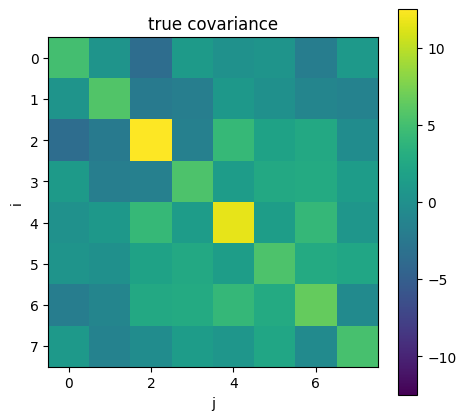

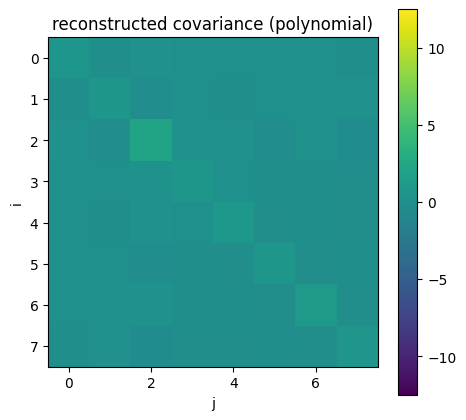

In [ ]:
fn.plot_cov_heatmaps(Sigma_true, Sigma_poly,
                  title_true="noisy inverse covariance",
                  title_rec ="reconstructed covariance (polynomial)")

In [ ]:
fn.plot_cov_heatmaps(Sigma_noise_poly, Sigma_poly,
                  title_true="noisy inverse covariance",
                  title_rec ="reconstructed covariance (polynomial)")